
## Avant de commencer le TP, 
- vérifiez que vous êtes sur un environnement GPU et python 3 : 
  
  Éxecution -> Modifier le type d'éxecution -> Type d'éxecution = python2, Accélerateur matériel = GPU

- Fichier -> Sauvegarder une copie dans mon drive

In [ ]:
!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git

Cloning into 'deep-learning-polytech-tp6-7'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 19 (delta 2), reused 7 (delta 1), pack-reused 8
Unpacking objects: 100% (19/19), done.


In [ ]:
cd deep-learning-polytech-tp6-7

/content/deep-learning-polytech-tp6-7


In [ ]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tme6 import *

PRINT_INTERVAL = 200
PATH="datasets"

In [ ]:
class ConvNet(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self, proba_dropout=0.5):
        super(ConvNet, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Dropout(p=proba_dropout),
            nn.Linear(1000, 10)
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv
        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input
        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491,0.482,0.447], std=[0.202,0.199,0.201]),
            transforms.RandomCrop(size=28),
            transforms.RandomHorizontalFlip()

        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491,0.482,0.447], std=[0.202,0.199,0.201]),
            transforms.CenterCrop(size=28)
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, proba_dropout=0.5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet(proba_dropout=proba_dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)

    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    min_loss = 1e+10
    epoch_min_loss=1
    count_epochs = 0       # if after strait 10 epochs the test loss is growing, we stop learning 
    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        if loss_test.val < min_loss:
          min_loss = loss_test.val
          epoch_min_loss = i
          count_epochs = 0
        else:
          count_epochs +=1
          if count_epochs == 10:
            break
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

        lr_sched.step()
      
    return min_loss, epoch_min_loss


Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/098]	Time 0.436s (0.436s)	Loss 2.3740 (2.3740)	Prec@1  12.5 ( 12.5)	Prec@5  52.1 ( 52.1)


<Figure size 432x288 with 0 Axes>

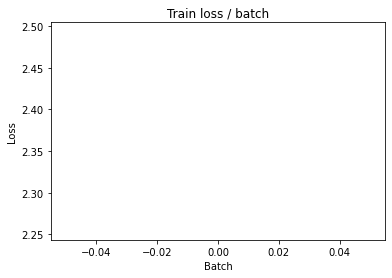


===============> Total time 15s	Avg loss 1.5920	Avg Prec@1 41.74 %	Avg Prec@5 88.35 %

[EVAL Batch 000/020]	Time 0.449s (0.449s)	Loss 1.2854 (1.2854)	Prec@1  51.4 ( 51.4)	Prec@5  95.9 ( 95.9)

===============> Total time 2s	Avg loss 1.2856	Avg Prec@1 53.06 %	Avg Prec@5 94.20 %



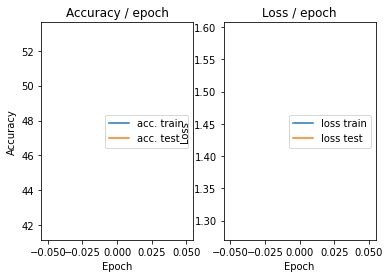

=== EPOCH 2 =====

[TRAIN Batch 000/098]	Time 0.419s (0.419s)	Loss 1.3022 (1.3022)	Prec@1  55.1 ( 55.1)	Prec@5  94.7 ( 94.7)


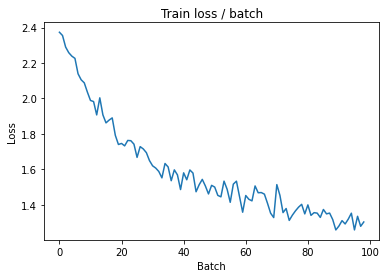


===============> Total time 15s	Avg loss 1.1887	Avg Prec@1 57.30 %	Avg Prec@5 95.18 %

[EVAL Batch 000/020]	Time 0.355s (0.355s)	Loss 1.1007 (1.1007)	Prec@1  60.7 ( 60.7)	Prec@5  96.7 ( 96.7)

===============> Total time 2s	Avg loss 1.1104	Avg Prec@1 61.61 %	Avg Prec@5 95.35 %



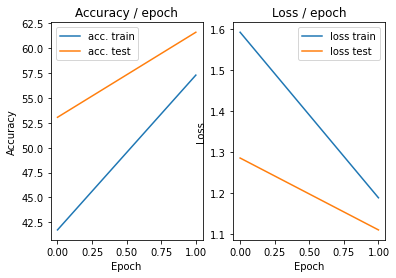

=== EPOCH 3 =====

[TRAIN Batch 000/098]	Time 0.424s (0.424s)	Loss 1.1240 (1.1240)	Prec@1  59.2 ( 59.2)	Prec@5  97.1 ( 97.1)


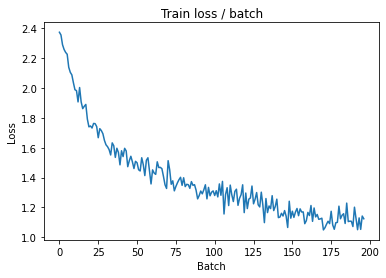


===============> Total time 15s	Avg loss 1.0199	Avg Prec@1 64.13 %	Avg Prec@5 96.50 %

[EVAL Batch 000/020]	Time 0.328s (0.328s)	Loss 0.9278 (0.9278)	Prec@1  67.4 ( 67.4)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.9700	Avg Prec@1 65.97 %	Avg Prec@5 96.78 %



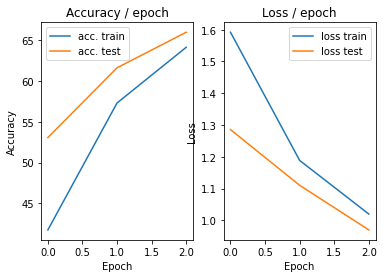

=== EPOCH 4 =====

[TRAIN Batch 000/098]	Time 0.446s (0.446s)	Loss 0.9512 (0.9512)	Prec@1  65.4 ( 65.4)	Prec@5  96.5 ( 96.5)


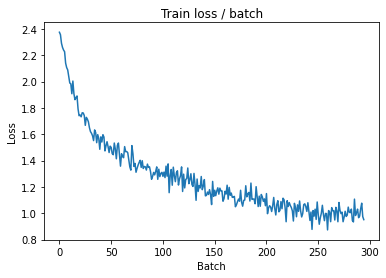


===============> Total time 15s	Avg loss 0.9138	Avg Prec@1 67.72 %	Avg Prec@5 97.36 %

[EVAL Batch 000/020]	Time 0.329s (0.329s)	Loss 0.8771 (0.8771)	Prec@1  70.1 ( 70.1)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.8849	Avg Prec@1 69.78 %	Avg Prec@5 97.35 %



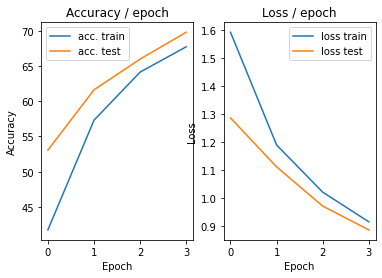

=== EPOCH 5 =====

[TRAIN Batch 000/098]	Time 0.439s (0.439s)	Loss 0.8957 (0.8957)	Prec@1  69.9 ( 69.9)	Prec@5  97.1 ( 97.1)


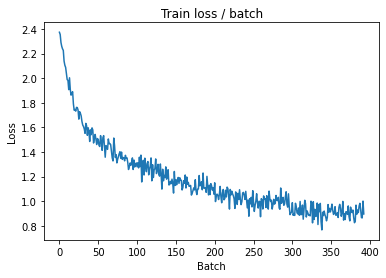


===============> Total time 15s	Avg loss 0.8376	Avg Prec@1 70.77 %	Avg Prec@5 97.65 %

[EVAL Batch 000/020]	Time 0.331s (0.331s)	Loss 0.8146 (0.8146)	Prec@1  71.9 ( 71.9)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.8119	Avg Prec@1 71.57 %	Avg Prec@5 97.95 %



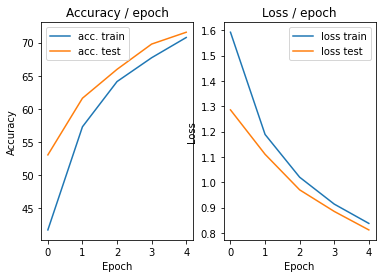

=== EPOCH 6 =====

[TRAIN Batch 000/098]	Time 0.424s (0.424s)	Loss 0.8452 (0.8452)	Prec@1  71.3 ( 71.3)	Prec@5  97.3 ( 97.3)


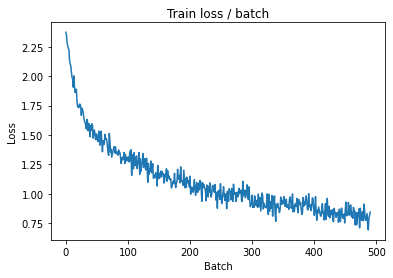


===============> Total time 15s	Avg loss 0.7838	Avg Prec@1 72.55 %	Avg Prec@5 97.97 %

[EVAL Batch 000/020]	Time 0.479s (0.479s)	Loss 0.7942 (0.7942)	Prec@1  72.9 ( 72.9)	Prec@5  98.8 ( 98.8)

===============> Total time 2s	Avg loss 0.7943	Avg Prec@1 73.32 %	Avg Prec@5 97.90 %



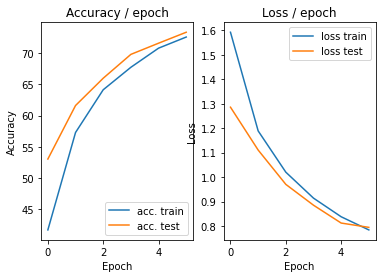

=== EPOCH 7 =====

[TRAIN Batch 000/098]	Time 0.412s (0.412s)	Loss 0.7543 (0.7543)	Prec@1  75.6 ( 75.6)	Prec@5  98.6 ( 98.6)


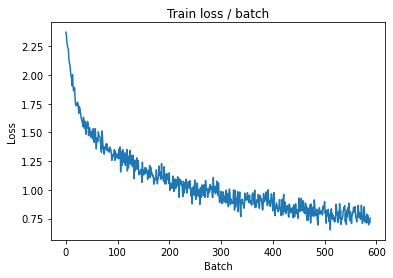


===============> Total time 15s	Avg loss 0.7420	Avg Prec@1 74.40 %	Avg Prec@5 98.23 %

[EVAL Batch 000/020]	Time 0.333s (0.333s)	Loss 0.7636 (0.7636)	Prec@1  73.4 ( 73.4)	Prec@5  98.2 ( 98.2)

===============> Total time 2s	Avg loss 0.7499	Avg Prec@1 73.76 %	Avg Prec@5 98.37 %



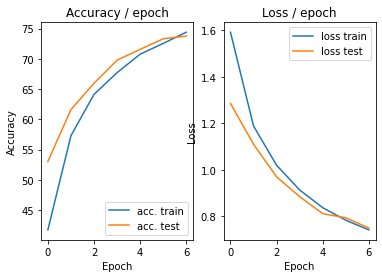

=== EPOCH 8 =====

[TRAIN Batch 000/098]	Time 0.428s (0.428s)	Loss 0.6618 (0.6618)	Prec@1  74.8 ( 74.8)	Prec@5  98.8 ( 98.8)


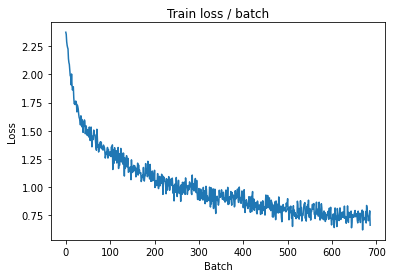


===============> Total time 15s	Avg loss 0.7103	Avg Prec@1 75.09 %	Avg Prec@5 98.36 %

[EVAL Batch 000/020]	Time 0.334s (0.334s)	Loss 0.7299 (0.7299)	Prec@1  75.8 ( 75.8)	Prec@5  98.6 ( 98.6)

===============> Total time 2s	Avg loss 0.7123	Avg Prec@1 75.74 %	Avg Prec@5 98.31 %



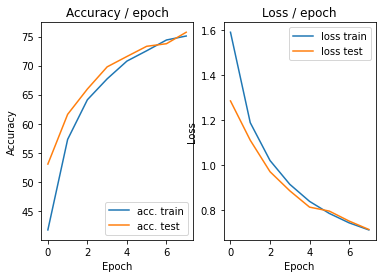

=== EPOCH 9 =====

[TRAIN Batch 000/098]	Time 0.456s (0.456s)	Loss 0.7226 (0.7226)	Prec@1  76.6 ( 76.6)	Prec@5  98.4 ( 98.4)


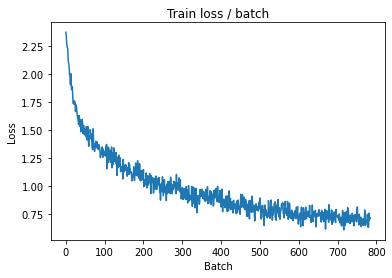


===============> Total time 15s	Avg loss 0.6738	Avg Prec@1 76.49 %	Avg Prec@5 98.47 %

[EVAL Batch 000/020]	Time 0.343s (0.343s)	Loss 0.6718 (0.6718)	Prec@1  76.2 ( 76.2)	Prec@5  98.6 ( 98.6)

===============> Total time 2s	Avg loss 0.6721	Avg Prec@1 76.78 %	Avg Prec@5 98.62 %



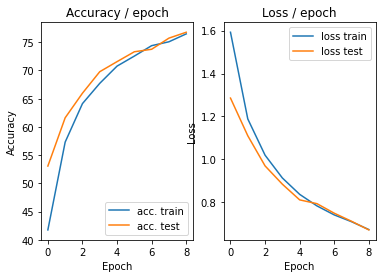

=== EPOCH 10 =====

[TRAIN Batch 000/098]	Time 0.423s (0.423s)	Loss 0.6361 (0.6361)	Prec@1  77.5 ( 77.5)	Prec@5  99.0 ( 99.0)


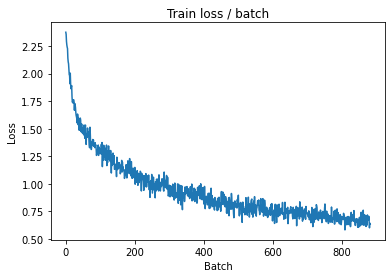


===============> Total time 15s	Avg loss 0.6446	Avg Prec@1 77.32 %	Avg Prec@5 98.66 %

[EVAL Batch 000/020]	Time 0.322s (0.322s)	Loss 0.6906 (0.6906)	Prec@1  76.4 ( 76.4)	Prec@5  99.0 ( 99.0)

===============> Total time 2s	Avg loss 0.6864	Avg Prec@1 76.46 %	Avg Prec@5 98.61 %



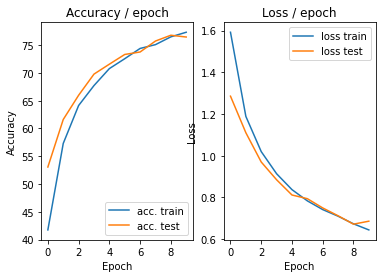

=== EPOCH 11 =====

[TRAIN Batch 000/098]	Time 0.432s (0.432s)	Loss 0.5806 (0.5806)	Prec@1  79.5 ( 79.5)	Prec@5  99.6 ( 99.6)


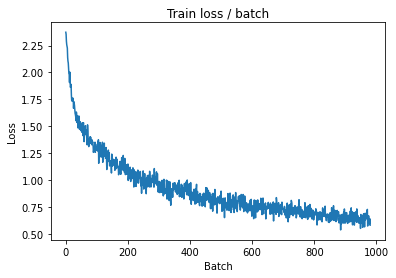


===============> Total time 15s	Avg loss 0.6255	Avg Prec@1 78.16 %	Avg Prec@5 98.70 %

[EVAL Batch 000/020]	Time 0.342s (0.342s)	Loss 0.6565 (0.6565)	Prec@1  75.8 ( 75.8)	Prec@5  98.6 ( 98.6)

===============> Total time 2s	Avg loss 0.6414	Avg Prec@1 77.36 %	Avg Prec@5 98.65 %



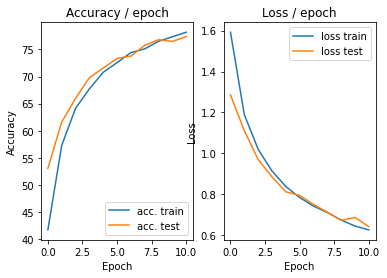

=== EPOCH 12 =====

[TRAIN Batch 000/098]	Time 0.556s (0.556s)	Loss 0.5423 (0.5423)	Prec@1  82.6 ( 82.6)	Prec@5  99.0 ( 99.0)


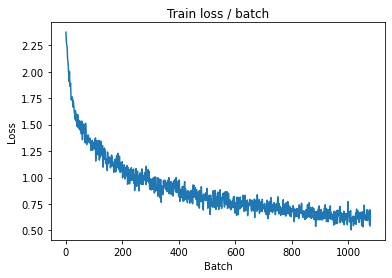


===============> Total time 15s	Avg loss 0.5997	Avg Prec@1 79.24 %	Avg Prec@5 98.79 %

[EVAL Batch 000/020]	Time 0.316s (0.316s)	Loss 0.6497 (0.6497)	Prec@1  77.9 ( 77.9)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6367	Avg Prec@1 78.03 %	Avg Prec@5 98.77 %



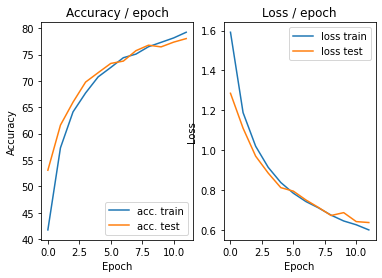

=== EPOCH 13 =====

[TRAIN Batch 000/098]	Time 0.434s (0.434s)	Loss 0.5534 (0.5534)	Prec@1  81.1 ( 81.1)	Prec@5  98.6 ( 98.6)


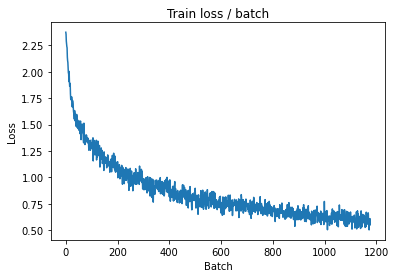


===============> Total time 15s	Avg loss 0.5803	Avg Prec@1 79.75 %	Avg Prec@5 98.86 %

[EVAL Batch 000/020]	Time 0.346s (0.346s)	Loss 0.6595 (0.6595)	Prec@1  76.8 ( 76.8)	Prec@5  99.0 ( 99.0)

===============> Total time 2s	Avg loss 0.6337	Avg Prec@1 78.36 %	Avg Prec@5 98.66 %



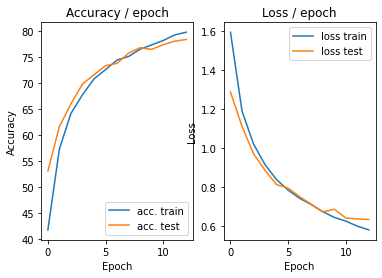

=== EPOCH 14 =====

[TRAIN Batch 000/098]	Time 0.430s (0.430s)	Loss 0.5628 (0.5628)	Prec@1  80.3 ( 80.3)	Prec@5  98.4 ( 98.4)


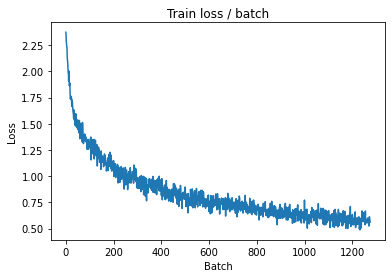


===============> Total time 15s	Avg loss 0.5644	Avg Prec@1 80.26 %	Avg Prec@5 98.99 %

[EVAL Batch 000/020]	Time 0.328s (0.328s)	Loss 0.6505 (0.6505)	Prec@1  77.5 ( 77.5)	Prec@5  98.8 ( 98.8)

===============> Total time 2s	Avg loss 0.6310	Avg Prec@1 78.39 %	Avg Prec@5 98.76 %



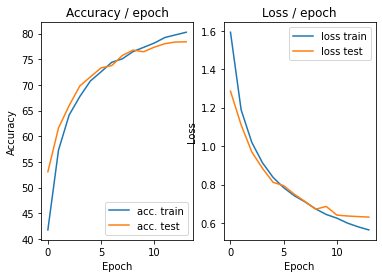

=== EPOCH 15 =====

[TRAIN Batch 000/098]	Time 0.419s (0.419s)	Loss 0.6498 (0.6498)	Prec@1  79.7 ( 79.7)	Prec@5  98.0 ( 98.0)


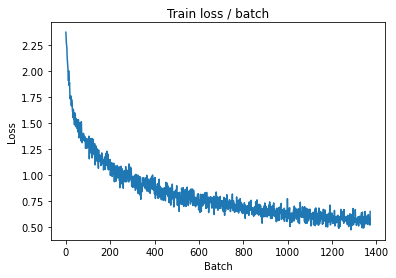


===============> Total time 15s	Avg loss 0.5530	Avg Prec@1 80.66 %	Avg Prec@5 98.99 %

[EVAL Batch 000/020]	Time 0.331s (0.331s)	Loss 0.5905 (0.5905)	Prec@1  78.5 ( 78.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5966	Avg Prec@1 79.46 %	Avg Prec@5 98.91 %



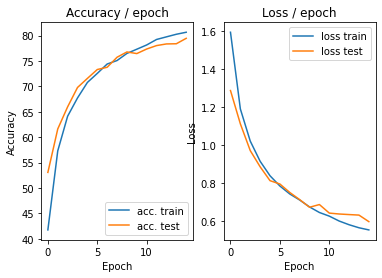

=== EPOCH 16 =====

[TRAIN Batch 000/098]	Time 0.407s (0.407s)	Loss 0.4863 (0.4863)	Prec@1  83.8 ( 83.8)	Prec@5  98.8 ( 98.8)


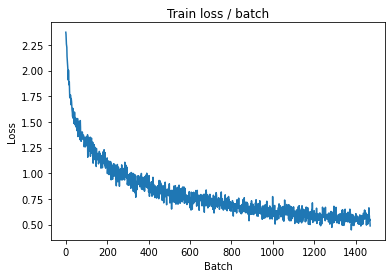


===============> Total time 15s	Avg loss 0.5389	Avg Prec@1 81.24 %	Avg Prec@5 99.07 %

[EVAL Batch 000/020]	Time 0.334s (0.334s)	Loss 0.5847 (0.5847)	Prec@1  79.3 ( 79.3)	Prec@5  99.4 ( 99.4)

===============> Total time 2s	Avg loss 0.5915	Avg Prec@1 79.76 %	Avg Prec@5 98.98 %



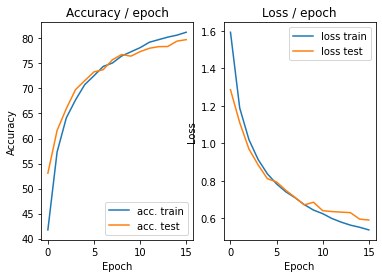

=== EPOCH 17 =====

[TRAIN Batch 000/098]	Time 0.429s (0.429s)	Loss 0.5055 (0.5055)	Prec@1  82.6 ( 82.6)	Prec@5  99.4 ( 99.4)


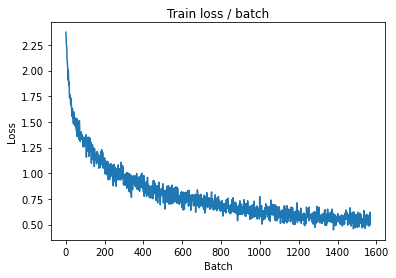


===============> Total time 15s	Avg loss 0.5177	Avg Prec@1 82.14 %	Avg Prec@5 99.13 %

[EVAL Batch 000/020]	Time 0.463s (0.463s)	Loss 0.5740 (0.5740)	Prec@1  80.3 ( 80.3)	Prec@5  99.4 ( 99.4)

===============> Total time 2s	Avg loss 0.5841	Avg Prec@1 80.20 %	Avg Prec@5 98.95 %



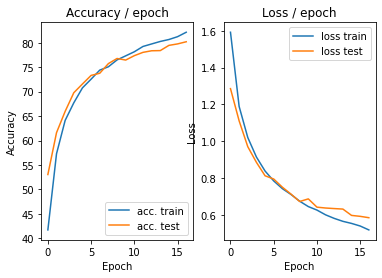

=== EPOCH 18 =====

[TRAIN Batch 000/098]	Time 0.437s (0.437s)	Loss 0.5462 (0.5462)	Prec@1  80.5 ( 80.5)	Prec@5  98.6 ( 98.6)


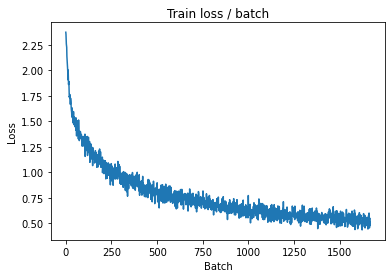


===============> Total time 15s	Avg loss 0.5121	Avg Prec@1 82.09 %	Avg Prec@5 99.21 %

[EVAL Batch 000/020]	Time 0.345s (0.345s)	Loss 0.5816 (0.5816)	Prec@1  80.1 ( 80.1)	Prec@5  99.0 ( 99.0)

===============> Total time 2s	Avg loss 0.6075	Avg Prec@1 79.52 %	Avg Prec@5 98.80 %



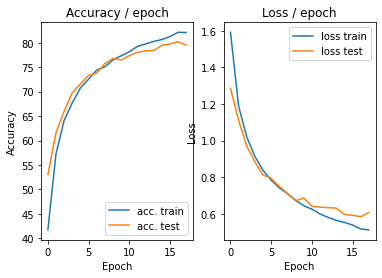

=== EPOCH 19 =====

[TRAIN Batch 000/098]	Time 0.421s (0.421s)	Loss 0.5803 (0.5803)	Prec@1  80.9 ( 80.9)	Prec@5  98.8 ( 98.8)


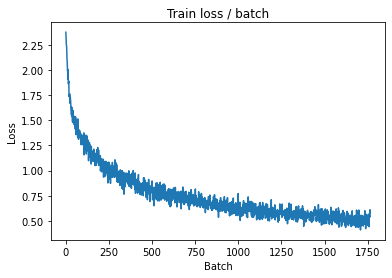


===============> Total time 15s	Avg loss 0.5006	Avg Prec@1 82.66 %	Avg Prec@5 99.17 %

[EVAL Batch 000/020]	Time 0.323s (0.323s)	Loss 0.5813 (0.5813)	Prec@1  79.9 ( 79.9)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5778	Avg Prec@1 80.26 %	Avg Prec@5 98.98 %



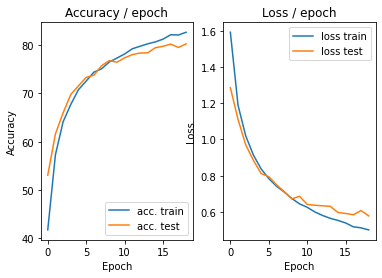

=== EPOCH 20 =====

[TRAIN Batch 000/098]	Time 0.426s (0.426s)	Loss 0.4106 (0.4106)	Prec@1  86.3 ( 86.3)	Prec@5  98.8 ( 98.8)


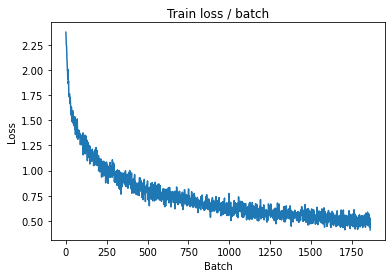


===============> Total time 14s	Avg loss 0.4858	Avg Prec@1 83.23 %	Avg Prec@5 99.25 %

[EVAL Batch 000/020]	Time 0.331s (0.331s)	Loss 0.5599 (0.5599)	Prec@1  81.2 ( 81.2)	Prec@5  99.4 ( 99.4)

===============> Total time 2s	Avg loss 0.5577	Avg Prec@1 81.09 %	Avg Prec@5 99.07 %



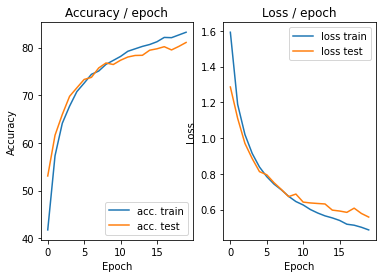

=== EPOCH 21 =====

[TRAIN Batch 000/098]	Time 0.433s (0.433s)	Loss 0.4239 (0.4239)	Prec@1  86.5 ( 86.5)	Prec@5  99.6 ( 99.6)


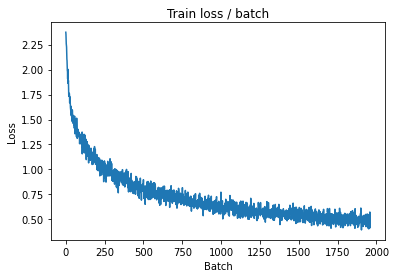


===============> Total time 15s	Avg loss 0.4793	Avg Prec@1 83.30 %	Avg Prec@5 99.22 %

[EVAL Batch 000/020]	Time 0.336s (0.336s)	Loss 0.6070 (0.6070)	Prec@1  78.9 ( 78.9)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5630	Avg Prec@1 80.97 %	Avg Prec@5 99.03 %



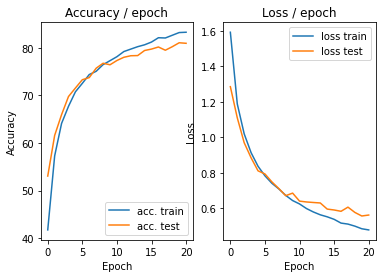

=== EPOCH 22 =====

[TRAIN Batch 000/098]	Time 0.397s (0.397s)	Loss 0.4265 (0.4265)	Prec@1  82.6 ( 82.6)	Prec@5  99.4 ( 99.4)


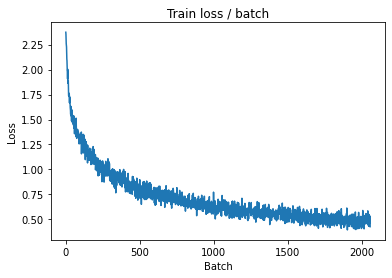


===============> Total time 15s	Avg loss 0.4703	Avg Prec@1 83.71 %	Avg Prec@5 99.30 %

[EVAL Batch 000/020]	Time 0.328s (0.328s)	Loss 0.5974 (0.5974)	Prec@1  78.1 ( 78.1)	Prec@5  98.8 ( 98.8)

===============> Total time 2s	Avg loss 0.5661	Avg Prec@1 80.63 %	Avg Prec@5 99.03 %



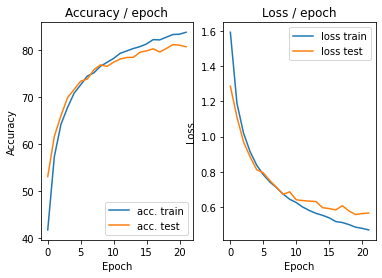

=== EPOCH 23 =====

[TRAIN Batch 000/098]	Time 0.569s (0.569s)	Loss 0.4317 (0.4317)	Prec@1  84.4 ( 84.4)	Prec@5  99.4 ( 99.4)


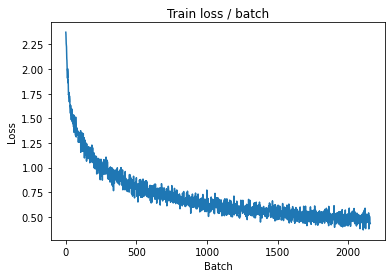


===============> Total time 15s	Avg loss 0.4647	Avg Prec@1 83.71 %	Avg Prec@5 99.26 %

[EVAL Batch 000/020]	Time 0.325s (0.325s)	Loss 0.5629 (0.5629)	Prec@1  81.2 ( 81.2)	Prec@5  99.0 ( 99.0)

===============> Total time 2s	Avg loss 0.5529	Avg Prec@1 81.19 %	Avg Prec@5 99.03 %



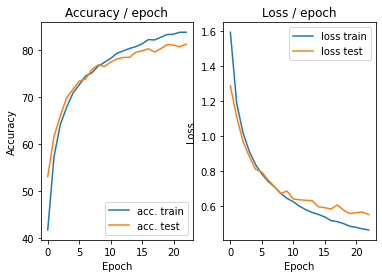

=== EPOCH 24 =====

[TRAIN Batch 000/098]	Time 0.420s (0.420s)	Loss 0.4378 (0.4378)	Prec@1  84.6 ( 84.6)	Prec@5  99.6 ( 99.6)


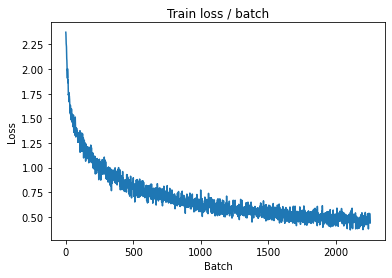


===============> Total time 14s	Avg loss 0.4477	Avg Prec@1 84.32 %	Avg Prec@5 99.32 %

[EVAL Batch 000/020]	Time 0.326s (0.326s)	Loss 0.5323 (0.5323)	Prec@1  81.8 ( 81.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5482	Avg Prec@1 81.39 %	Avg Prec@5 99.02 %



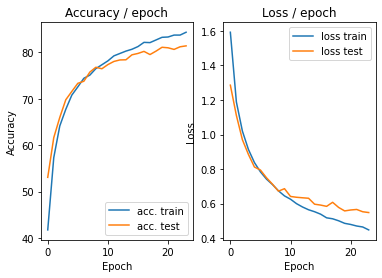

=== EPOCH 25 =====

[TRAIN Batch 000/098]	Time 0.430s (0.430s)	Loss 0.4728 (0.4728)	Prec@1  83.6 ( 83.6)	Prec@5  99.2 ( 99.2)


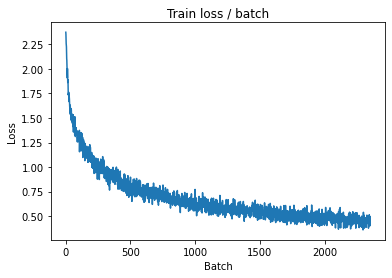


===============> Total time 14s	Avg loss 0.4468	Avg Prec@1 84.41 %	Avg Prec@5 99.34 %

[EVAL Batch 000/020]	Time 0.322s (0.322s)	Loss 0.5481 (0.5481)	Prec@1  81.2 ( 81.2)	Prec@5  99.0 ( 99.0)

===============> Total time 2s	Avg loss 0.5467	Avg Prec@1 81.25 %	Avg Prec@5 99.05 %



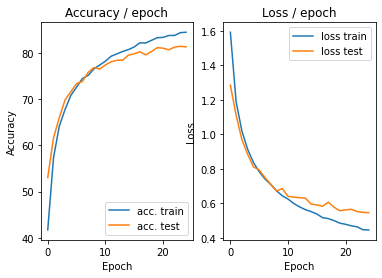

=== EPOCH 26 =====

[TRAIN Batch 000/098]	Time 0.421s (0.421s)	Loss 0.4197 (0.4197)	Prec@1  84.6 ( 84.6)	Prec@5  99.6 ( 99.6)


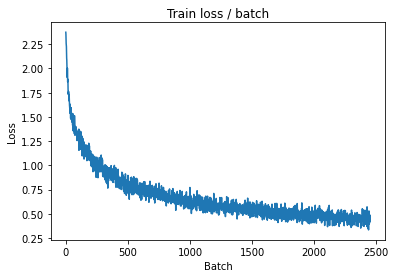


===============> Total time 14s	Avg loss 0.4395	Avg Prec@1 84.64 %	Avg Prec@5 99.37 %

[EVAL Batch 000/020]	Time 0.339s (0.339s)	Loss 0.5190 (0.5190)	Prec@1  83.2 ( 83.2)	Prec@5  99.0 ( 99.0)

===============> Total time 2s	Avg loss 0.5352	Avg Prec@1 81.67 %	Avg Prec@5 98.98 %



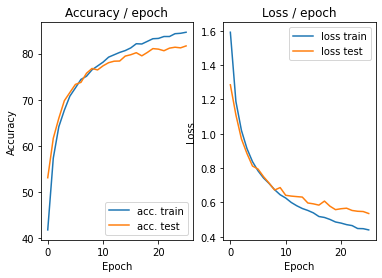

=== EPOCH 27 =====

[TRAIN Batch 000/098]	Time 0.422s (0.422s)	Loss 0.4082 (0.4082)	Prec@1  85.5 ( 85.5)	Prec@5  99.0 ( 99.0)


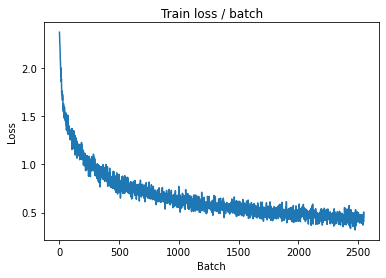


===============> Total time 14s	Avg loss 0.4304	Avg Prec@1 84.97 %	Avg Prec@5 99.38 %

[EVAL Batch 000/020]	Time 0.331s (0.331s)	Loss 0.5394 (0.5394)	Prec@1  80.3 ( 80.3)	Prec@5  98.8 ( 98.8)

===============> Total time 2s	Avg loss 0.5444	Avg Prec@1 81.48 %	Avg Prec@5 99.04 %



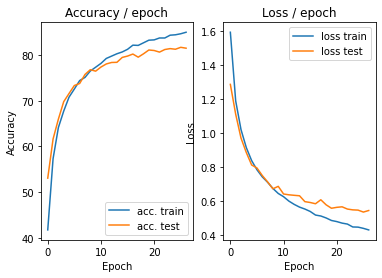

=== EPOCH 28 =====

[TRAIN Batch 000/098]	Time 0.424s (0.424s)	Loss 0.5129 (0.5129)	Prec@1  81.4 ( 81.4)	Prec@5  98.4 ( 98.4)


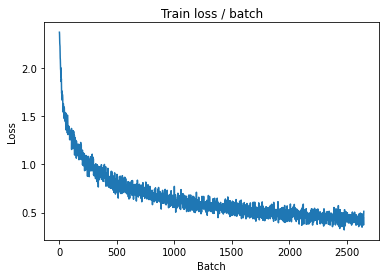


===============> Total time 15s	Avg loss 0.4247	Avg Prec@1 85.39 %	Avg Prec@5 99.39 %

[EVAL Batch 000/020]	Time 0.463s (0.463s)	Loss 0.5382 (0.5382)	Prec@1  80.7 ( 80.7)	Prec@5  99.4 ( 99.4)

===============> Total time 2s	Avg loss 0.5421	Avg Prec@1 81.31 %	Avg Prec@5 99.10 %



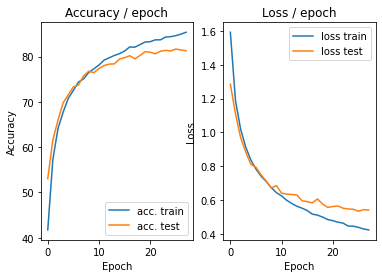

=== EPOCH 29 =====

[TRAIN Batch 000/098]	Time 0.423s (0.423s)	Loss 0.4706 (0.4706)	Prec@1  81.8 ( 81.8)	Prec@5  99.6 ( 99.6)


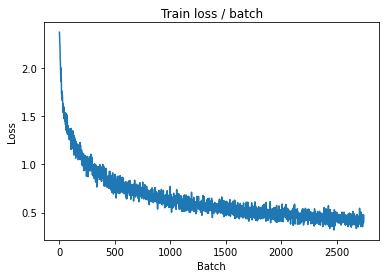


===============> Total time 14s	Avg loss 0.4187	Avg Prec@1 85.31 %	Avg Prec@5 99.44 %

[EVAL Batch 000/020]	Time 0.325s (0.325s)	Loss 0.5159 (0.5159)	Prec@1  83.4 ( 83.4)	Prec@5  99.4 ( 99.4)

===============> Total time 2s	Avg loss 0.5380	Avg Prec@1 82.11 %	Avg Prec@5 99.15 %



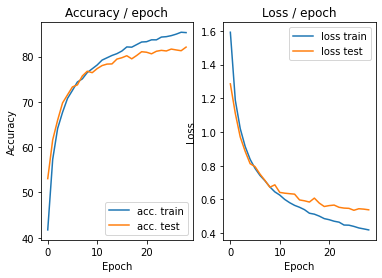

=== EPOCH 30 =====

[TRAIN Batch 000/098]	Time 0.416s (0.416s)	Loss 0.4670 (0.4670)	Prec@1  84.2 ( 84.2)	Prec@5  99.4 ( 99.4)


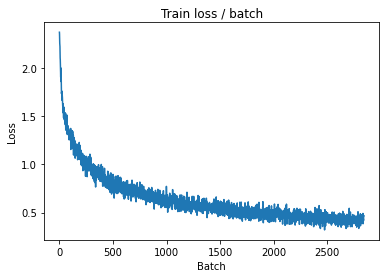


===============> Total time 14s	Avg loss 0.4160	Avg Prec@1 85.57 %	Avg Prec@5 99.41 %

[EVAL Batch 000/020]	Time 0.329s (0.329s)	Loss 0.5145 (0.5145)	Prec@1  82.0 ( 82.0)	Prec@5  99.0 ( 99.0)

===============> Total time 2s	Avg loss 0.5201	Avg Prec@1 82.52 %	Avg Prec@5 99.19 %



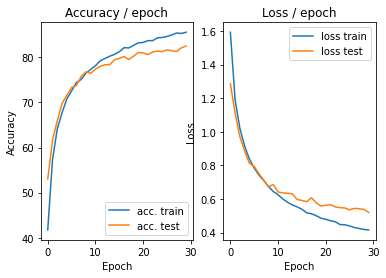

=== EPOCH 31 =====

[TRAIN Batch 000/098]	Time 0.402s (0.402s)	Loss 0.4668 (0.4668)	Prec@1  84.4 ( 84.4)	Prec@5  99.6 ( 99.6)


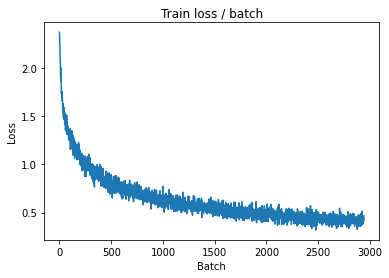


===============> Total time 15s	Avg loss 0.4084	Avg Prec@1 85.82 %	Avg Prec@5 99.47 %

[EVAL Batch 000/020]	Time 0.333s (0.333s)	Loss 0.5396 (0.5396)	Prec@1  82.2 ( 82.2)	Prec@5  98.8 ( 98.8)

===============> Total time 2s	Avg loss 0.5249	Avg Prec@1 82.35 %	Avg Prec@5 99.06 %



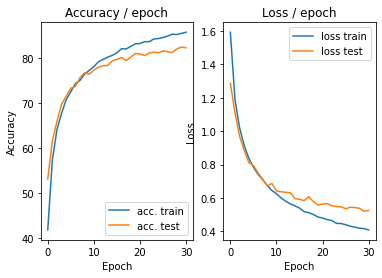

=== EPOCH 32 =====

[TRAIN Batch 000/098]	Time 0.433s (0.433s)	Loss 0.3453 (0.3453)	Prec@1  87.1 ( 87.1)	Prec@5  99.0 ( 99.0)


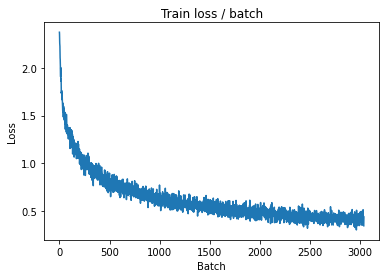


===============> Total time 15s	Avg loss 0.4005	Avg Prec@1 86.13 %	Avg Prec@5 99.45 %

[EVAL Batch 000/020]	Time 0.347s (0.347s)	Loss 0.5424 (0.5424)	Prec@1  81.8 ( 81.8)	Prec@5  98.8 ( 98.8)

===============> Total time 2s	Avg loss 0.5285	Avg Prec@1 82.01 %	Avg Prec@5 99.07 %



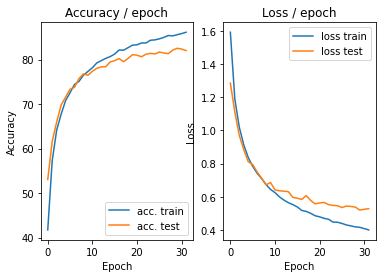

=== EPOCH 33 =====

[TRAIN Batch 000/098]	Time 0.422s (0.422s)	Loss 0.3875 (0.3875)	Prec@1  86.3 ( 86.3)	Prec@5  99.4 ( 99.4)


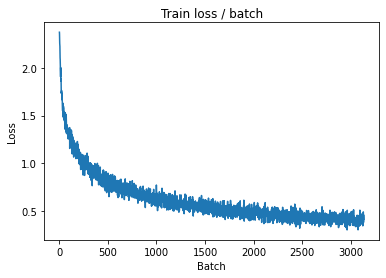


===============> Total time 15s	Avg loss 0.4009	Avg Prec@1 85.88 %	Avg Prec@5 99.50 %

[EVAL Batch 000/020]	Time 0.334s (0.334s)	Loss 0.4894 (0.4894)	Prec@1  83.2 ( 83.2)	Prec@5  99.4 ( 99.4)

===============> Total time 2s	Avg loss 0.5312	Avg Prec@1 82.29 %	Avg Prec@5 99.05 %



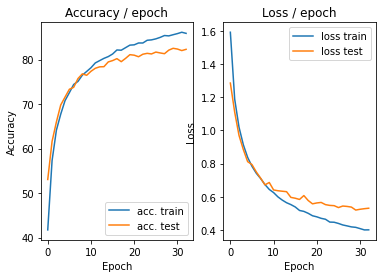

=== EPOCH 34 =====

[TRAIN Batch 000/098]	Time 0.570s (0.570s)	Loss 0.3748 (0.3748)	Prec@1  87.7 ( 87.7)	Prec@5  99.2 ( 99.2)


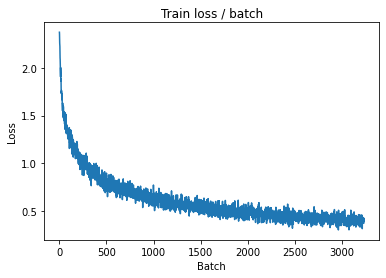


===============> Total time 15s	Avg loss 0.3936	Avg Prec@1 86.09 %	Avg Prec@5 99.49 %

[EVAL Batch 000/020]	Time 0.338s (0.338s)	Loss 0.5241 (0.5241)	Prec@1  82.0 ( 82.0)	Prec@5  99.4 ( 99.4)

===============> Total time 2s	Avg loss 0.5239	Avg Prec@1 82.50 %	Avg Prec@5 99.16 %



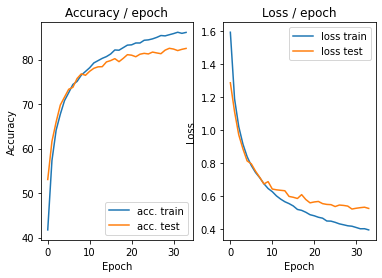

=== EPOCH 35 =====

[TRAIN Batch 000/098]	Time 0.420s (0.420s)	Loss 0.3395 (0.3395)	Prec@1  88.3 ( 88.3)	Prec@5  99.4 ( 99.4)


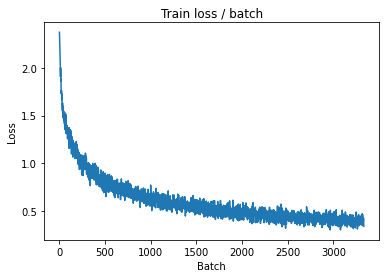


===============> Total time 15s	Avg loss 0.3887	Avg Prec@1 86.51 %	Avg Prec@5 99.50 %

[EVAL Batch 000/020]	Time 0.338s (0.338s)	Loss 0.5262 (0.5262)	Prec@1  82.0 ( 82.0)	Prec@5  99.6 ( 99.6)

===============> Total time 2s	Avg loss 0.5159	Avg Prec@1 82.55 %	Avg Prec@5 99.21 %



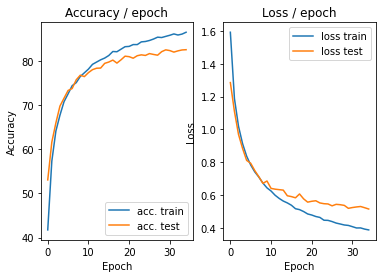

=== EPOCH 36 =====

[TRAIN Batch 000/098]	Time 0.428s (0.428s)	Loss 0.3969 (0.3969)	Prec@1  85.5 ( 85.5)	Prec@5  99.6 ( 99.6)


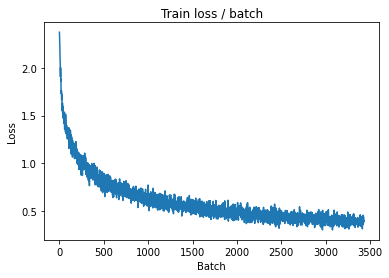


===============> Total time 15s	Avg loss 0.3859	Avg Prec@1 86.51 %	Avg Prec@5 99.55 %

[EVAL Batch 000/020]	Time 0.336s (0.336s)	Loss 0.5141 (0.5141)	Prec@1  82.4 ( 82.4)	Prec@5  99.4 ( 99.4)

===============> Total time 2s	Avg loss 0.5233	Avg Prec@1 82.35 %	Avg Prec@5 99.15 %



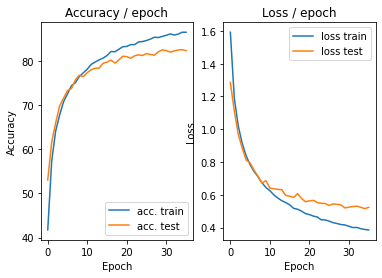

=== EPOCH 37 =====

[TRAIN Batch 000/098]	Time 0.422s (0.422s)	Loss 0.3759 (0.3759)	Prec@1  87.7 ( 87.7)	Prec@5  99.8 ( 99.8)


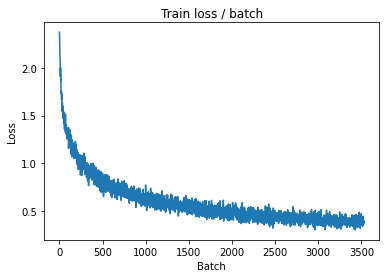


===============> Total time 15s	Avg loss 0.3839	Avg Prec@1 86.55 %	Avg Prec@5 99.56 %

[EVAL Batch 000/020]	Time 0.338s (0.338s)	Loss 0.5283 (0.5283)	Prec@1  81.2 ( 81.2)	Prec@5  99.0 ( 99.0)

===============> Total time 2s	Avg loss 0.5207	Avg Prec@1 82.47 %	Avg Prec@5 99.10 %



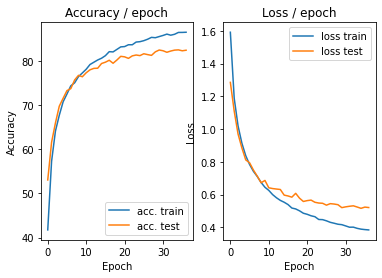

=== EPOCH 38 =====

[TRAIN Batch 000/098]	Time 0.417s (0.417s)	Loss 0.3444 (0.3444)	Prec@1  87.7 ( 87.7)	Prec@5  99.6 ( 99.6)


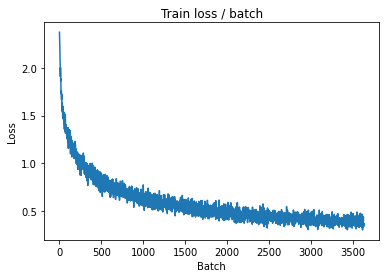


===============> Total time 15s	Avg loss 0.3770	Avg Prec@1 86.88 %	Avg Prec@5 99.53 %

[EVAL Batch 000/020]	Time 0.338s (0.338s)	Loss 0.5098 (0.5098)	Prec@1  84.0 ( 84.0)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5081	Avg Prec@1 83.03 %	Avg Prec@5 99.16 %



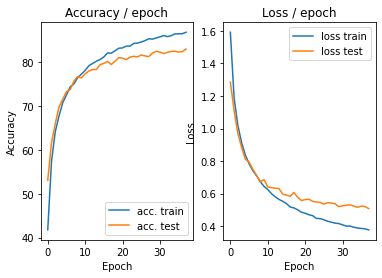

=== EPOCH 39 =====

[TRAIN Batch 000/098]	Time 0.428s (0.428s)	Loss 0.3799 (0.3799)	Prec@1  87.3 ( 87.3)	Prec@5  99.6 ( 99.6)


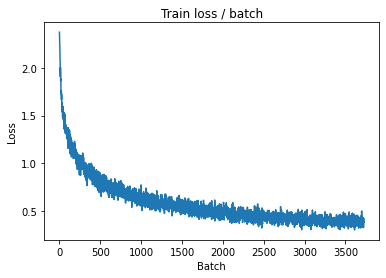


===============> Total time 15s	Avg loss 0.3722	Avg Prec@1 87.01 %	Avg Prec@5 99.58 %

[EVAL Batch 000/020]	Time 0.477s (0.477s)	Loss 0.5025 (0.5025)	Prec@1  82.8 ( 82.8)	Prec@5  99.4 ( 99.4)

===============> Total time 2s	Avg loss 0.5104	Avg Prec@1 83.00 %	Avg Prec@5 99.24 %



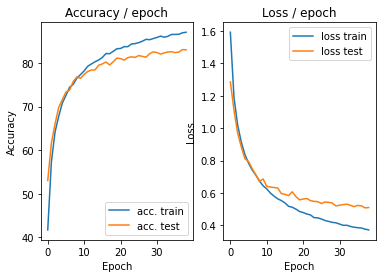

=== EPOCH 40 =====

[TRAIN Batch 000/098]	Time 0.431s (0.431s)	Loss 0.3888 (0.3888)	Prec@1  87.1 ( 87.1)	Prec@5  99.6 ( 99.6)


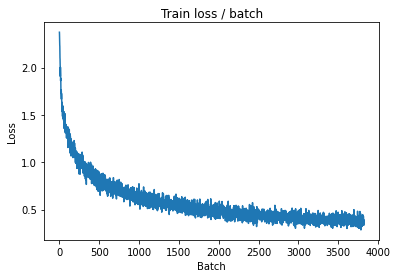


===============> Total time 15s	Avg loss 0.3716	Avg Prec@1 87.07 %	Avg Prec@5 99.57 %

[EVAL Batch 000/020]	Time 0.327s (0.327s)	Loss 0.5168 (0.5168)	Prec@1  81.8 ( 81.8)	Prec@5  99.4 ( 99.4)

===============> Total time 2s	Avg loss 0.5194	Avg Prec@1 82.83 %	Avg Prec@5 99.21 %



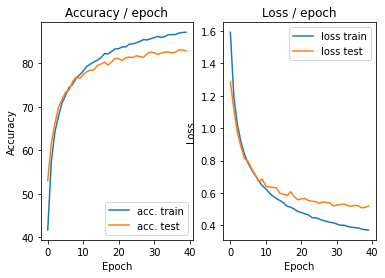

=== EPOCH 41 =====

[TRAIN Batch 000/098]	Time 0.471s (0.471s)	Loss 0.3292 (0.3292)	Prec@1  87.7 ( 87.7)	Prec@5  99.6 ( 99.6)


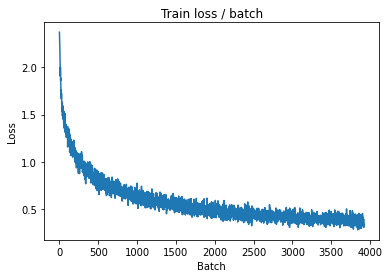


===============> Total time 15s	Avg loss 0.3710	Avg Prec@1 87.17 %	Avg Prec@5 99.56 %

[EVAL Batch 000/020]	Time 0.345s (0.345s)	Loss 0.5011 (0.5011)	Prec@1  83.0 ( 83.0)	Prec@5  98.8 ( 98.8)

===============> Total time 2s	Avg loss 0.5091	Avg Prec@1 83.11 %	Avg Prec@5 99.18 %



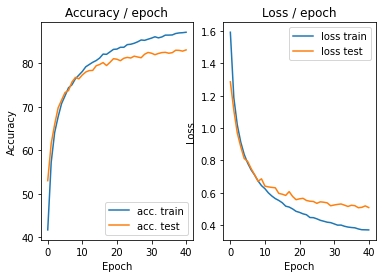

=== EPOCH 42 =====

[TRAIN Batch 000/098]	Time 0.435s (0.435s)	Loss 0.3083 (0.3083)	Prec@1  88.1 ( 88.1)	Prec@5  99.8 ( 99.8)


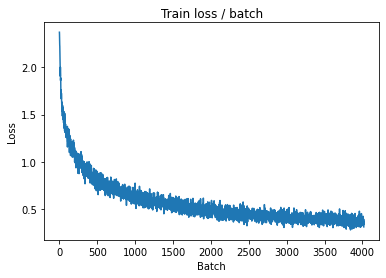


===============> Total time 15s	Avg loss 0.3664	Avg Prec@1 87.11 %	Avg Prec@5 99.55 %

[EVAL Batch 000/020]	Time 0.329s (0.329s)	Loss 0.5251 (0.5251)	Prec@1  82.8 ( 82.8)	Prec@5  99.0 ( 99.0)

===============> Total time 2s	Avg loss 0.5154	Avg Prec@1 82.64 %	Avg Prec@5 99.23 %



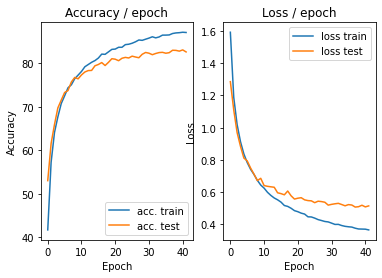

=== EPOCH 43 =====

[TRAIN Batch 000/098]	Time 0.431s (0.431s)	Loss 0.3584 (0.3584)	Prec@1  87.5 ( 87.5)	Prec@5  99.4 ( 99.4)


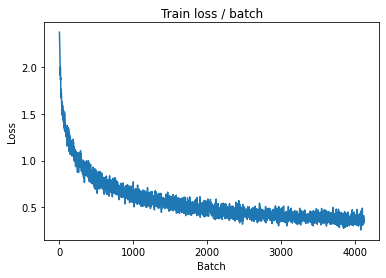


===============> Total time 15s	Avg loss 0.3628	Avg Prec@1 87.17 %	Avg Prec@5 99.57 %

[EVAL Batch 000/020]	Time 0.336s (0.336s)	Loss 0.5083 (0.5083)	Prec@1  83.4 ( 83.4)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5082	Avg Prec@1 83.22 %	Avg Prec@5 99.17 %



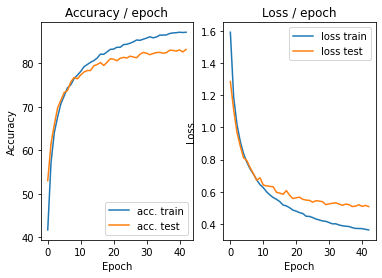

=== EPOCH 44 =====

[TRAIN Batch 000/098]	Time 0.410s (0.410s)	Loss 0.2976 (0.2976)	Prec@1  90.0 ( 90.0)	Prec@5  99.6 ( 99.6)


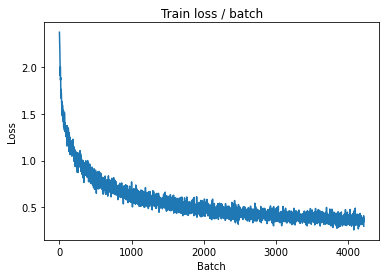


===============> Total time 15s	Avg loss 0.3599	Avg Prec@1 87.48 %	Avg Prec@5 99.56 %

[EVAL Batch 000/020]	Time 0.325s (0.325s)	Loss 0.4882 (0.4882)	Prec@1  83.8 ( 83.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5063	Avg Prec@1 83.32 %	Avg Prec@5 99.18 %



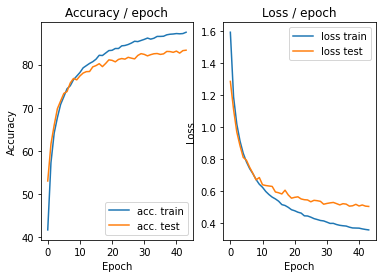

=== EPOCH 45 =====

[TRAIN Batch 000/098]	Time 0.548s (0.548s)	Loss 0.3197 (0.3197)	Prec@1  89.3 ( 89.3)	Prec@5  99.4 ( 99.4)


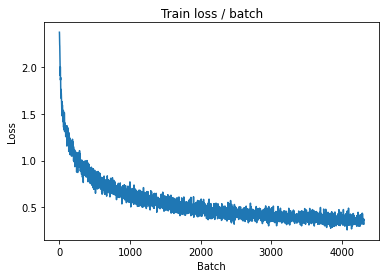


===============> Total time 15s	Avg loss 0.3608	Avg Prec@1 87.28 %	Avg Prec@5 99.57 %

[EVAL Batch 000/020]	Time 0.323s (0.323s)	Loss 0.4819 (0.4819)	Prec@1  82.2 ( 82.2)	Prec@5  99.6 ( 99.6)

===============> Total time 2s	Avg loss 0.5110	Avg Prec@1 82.95 %	Avg Prec@5 99.24 %



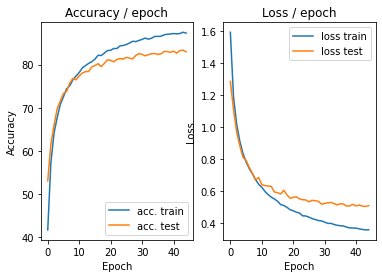

=== EPOCH 46 =====

[TRAIN Batch 000/098]	Time 0.438s (0.438s)	Loss 0.3725 (0.3725)	Prec@1  85.9 ( 85.9)	Prec@5  99.8 ( 99.8)


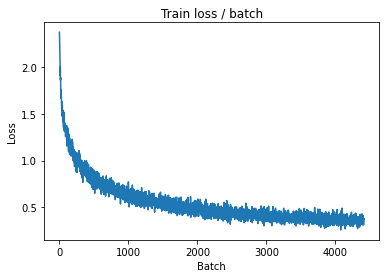


===============> Total time 15s	Avg loss 0.3544	Avg Prec@1 87.55 %	Avg Prec@5 99.61 %

[EVAL Batch 000/020]	Time 0.332s (0.332s)	Loss 0.5007 (0.5007)	Prec@1  81.6 ( 81.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5071	Avg Prec@1 82.86 %	Avg Prec@5 99.23 %



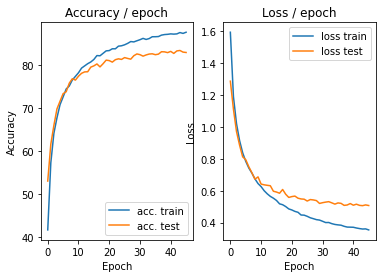

=== EPOCH 47 =====

[TRAIN Batch 000/098]	Time 0.425s (0.425s)	Loss 0.3685 (0.3685)	Prec@1  86.7 ( 86.7)	Prec@5  99.0 ( 99.0)


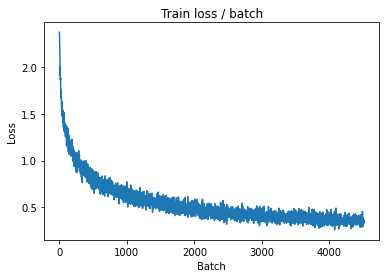


===============> Total time 15s	Avg loss 0.3566	Avg Prec@1 87.43 %	Avg Prec@5 99.59 %

[EVAL Batch 000/020]	Time 0.329s (0.329s)	Loss 0.5056 (0.5056)	Prec@1  82.6 ( 82.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5128	Avg Prec@1 83.02 %	Avg Prec@5 99.20 %



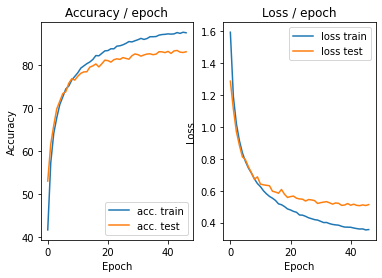

=== EPOCH 48 =====

[TRAIN Batch 000/098]	Time 0.432s (0.432s)	Loss 0.3011 (0.3011)	Prec@1  89.3 ( 89.3)	Prec@5  99.8 ( 99.8)


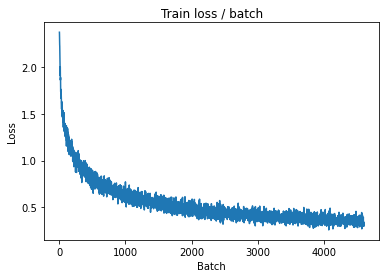


===============> Total time 15s	Avg loss 0.3533	Avg Prec@1 87.68 %	Avg Prec@5 99.60 %

[EVAL Batch 000/020]	Time 0.342s (0.342s)	Loss 0.4756 (0.4756)	Prec@1  83.0 ( 83.0)	Prec@5  99.0 ( 99.0)

===============> Total time 2s	Avg loss 0.5018	Avg Prec@1 83.35 %	Avg Prec@5 99.14 %



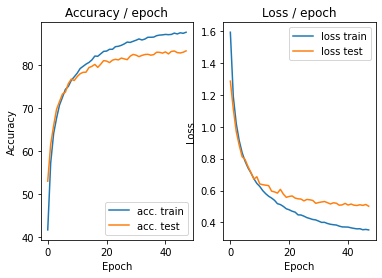

=== EPOCH 49 =====

[TRAIN Batch 000/098]	Time 0.413s (0.413s)	Loss 0.3024 (0.3024)	Prec@1  89.3 ( 89.3)	Prec@5 100.0 (100.0)


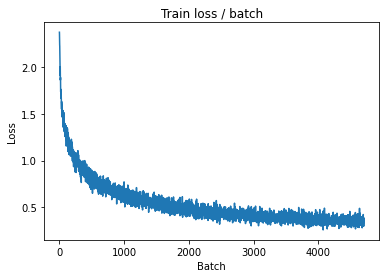


===============> Total time 15s	Avg loss 0.3513	Avg Prec@1 87.69 %	Avg Prec@5 99.60 %

[EVAL Batch 000/020]	Time 0.326s (0.326s)	Loss 0.4896 (0.4896)	Prec@1  83.2 ( 83.2)	Prec@5  99.0 ( 99.0)

===============> Total time 2s	Avg loss 0.5032	Avg Prec@1 83.31 %	Avg Prec@5 99.24 %



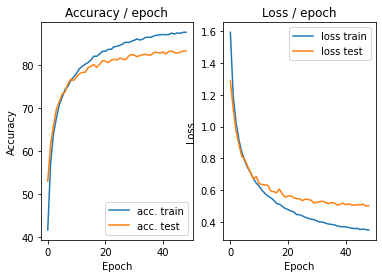

=== EPOCH 50 =====

[TRAIN Batch 000/098]	Time 0.422s (0.422s)	Loss 0.3363 (0.3363)	Prec@1  88.9 ( 88.9)	Prec@5  99.6 ( 99.6)


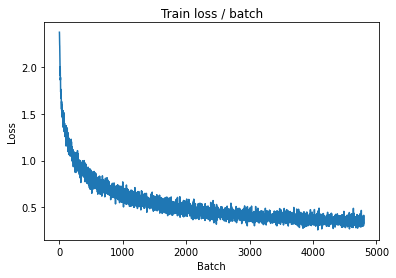


===============> Total time 15s	Avg loss 0.3457	Avg Prec@1 87.87 %	Avg Prec@5 99.60 %

[EVAL Batch 000/020]	Time 0.480s (0.480s)	Loss 0.4828 (0.4828)	Prec@1  83.4 ( 83.4)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5007	Avg Prec@1 83.46 %	Avg Prec@5 99.17 %



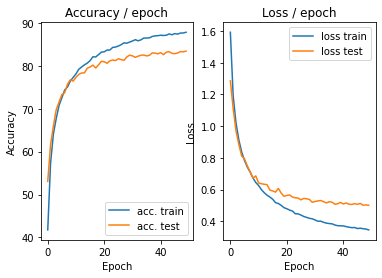

=== EPOCH 51 =====

[TRAIN Batch 000/098]	Time 0.416s (0.416s)	Loss 0.2595 (0.2595)	Prec@1  89.8 ( 89.8)	Prec@5 100.0 (100.0)


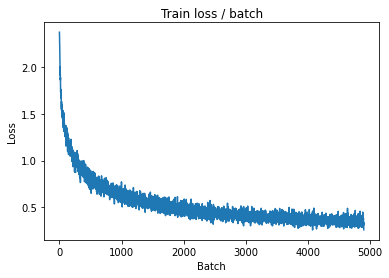


===============> Total time 15s	Avg loss 0.3443	Avg Prec@1 88.09 %	Avg Prec@5 99.65 %

[EVAL Batch 000/020]	Time 0.325s (0.325s)	Loss 0.4823 (0.4823)	Prec@1  84.2 ( 84.2)	Prec@5  99.4 ( 99.4)

===============> Total time 2s	Avg loss 0.5027	Avg Prec@1 83.40 %	Avg Prec@5 99.22 %



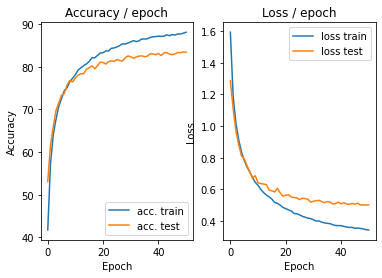

=== EPOCH 52 =====

[TRAIN Batch 000/098]	Time 0.440s (0.440s)	Loss 0.4167 (0.4167)	Prec@1  85.4 ( 85.4)	Prec@5  99.4 ( 99.4)


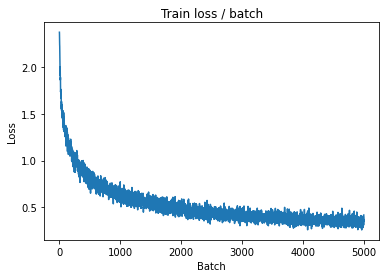


===============> Total time 15s	Avg loss 0.3448	Avg Prec@1 87.97 %	Avg Prec@5 99.67 %

[EVAL Batch 000/020]	Time 0.349s (0.349s)	Loss 0.4888 (0.4888)	Prec@1  83.6 ( 83.6)	Prec@5  99.4 ( 99.4)

===============> Total time 2s	Avg loss 0.5015	Avg Prec@1 83.30 %	Avg Prec@5 99.23 %



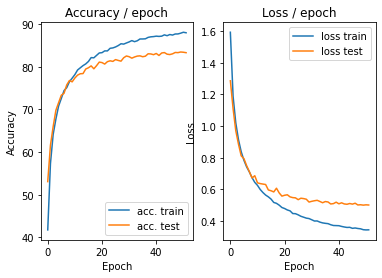

=== EPOCH 53 =====

[TRAIN Batch 000/098]	Time 0.427s (0.427s)	Loss 0.3837 (0.3837)	Prec@1  85.7 ( 85.7)	Prec@5  99.8 ( 99.8)


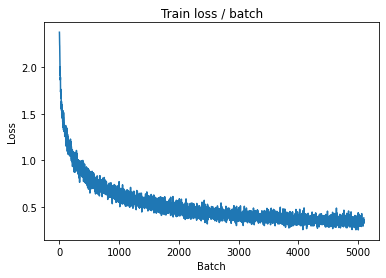


===============> Total time 15s	Avg loss 0.3448	Avg Prec@1 88.04 %	Avg Prec@5 99.62 %

[EVAL Batch 000/020]	Time 0.322s (0.322s)	Loss 0.4877 (0.4877)	Prec@1  83.0 ( 83.0)	Prec@5  99.6 ( 99.6)

===============> Total time 2s	Avg loss 0.5013	Avg Prec@1 83.34 %	Avg Prec@5 99.21 %



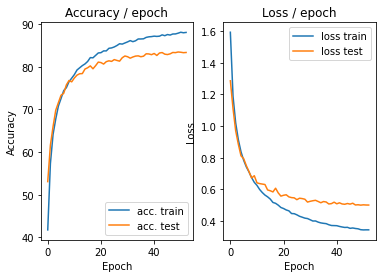

=== EPOCH 54 =====

[TRAIN Batch 000/098]	Time 0.423s (0.423s)	Loss 0.3282 (0.3282)	Prec@1  88.1 ( 88.1)	Prec@5  99.6 ( 99.6)


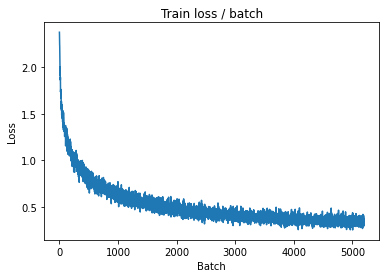


===============> Total time 15s	Avg loss 0.3418	Avg Prec@1 88.09 %	Avg Prec@5 99.66 %

[EVAL Batch 000/020]	Time 0.324s (0.324s)	Loss 0.4880 (0.4880)	Prec@1  82.6 ( 82.6)	Prec@5  99.4 ( 99.4)

===============> Total time 2s	Avg loss 0.5002	Avg Prec@1 83.51 %	Avg Prec@5 99.20 %



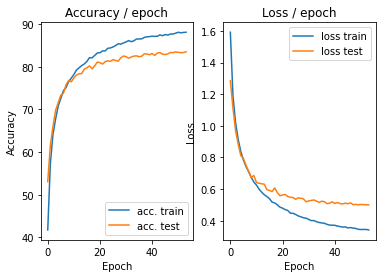

=== EPOCH 55 =====

[TRAIN Batch 000/098]	Time 0.453s (0.453s)	Loss 0.3106 (0.3106)	Prec@1  89.1 ( 89.1)	Prec@5  99.6 ( 99.6)


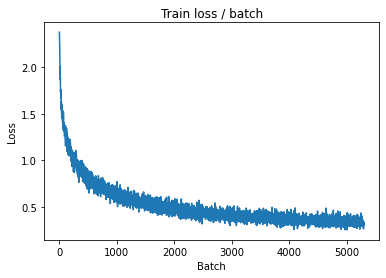


===============> Total time 15s	Avg loss 0.3386	Avg Prec@1 88.02 %	Avg Prec@5 99.67 %

[EVAL Batch 000/020]	Time 0.331s (0.331s)	Loss 0.4828 (0.4828)	Prec@1  83.2 ( 83.2)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.4969	Avg Prec@1 83.47 %	Avg Prec@5 99.28 %



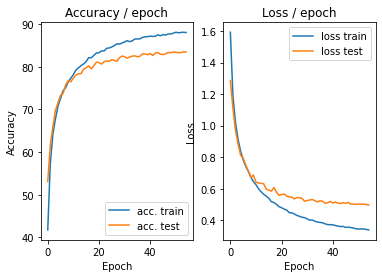

=== EPOCH 56 =====

[TRAIN Batch 000/098]	Time 0.581s (0.581s)	Loss 0.2942 (0.2942)	Prec@1  90.2 ( 90.2)	Prec@5  99.6 ( 99.6)


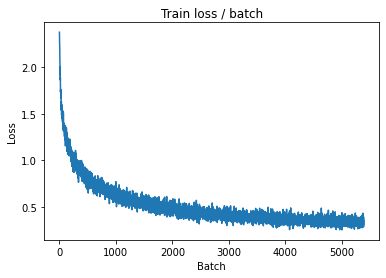


===============> Total time 15s	Avg loss 0.3346	Avg Prec@1 88.31 %	Avg Prec@5 99.67 %

[EVAL Batch 000/020]	Time 0.350s (0.350s)	Loss 0.4798 (0.4798)	Prec@1  83.0 ( 83.0)	Prec@5  99.6 ( 99.6)

===============> Total time 2s	Avg loss 0.5022	Avg Prec@1 83.22 %	Avg Prec@5 99.23 %



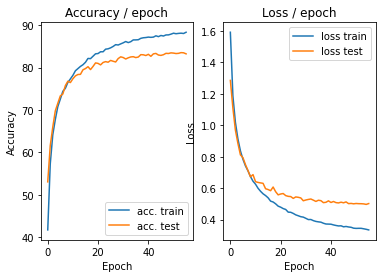

=== EPOCH 57 =====

[TRAIN Batch 000/098]	Time 0.432s (0.432s)	Loss 0.2909 (0.2909)	Prec@1  90.4 ( 90.4)	Prec@5  99.8 ( 99.8)


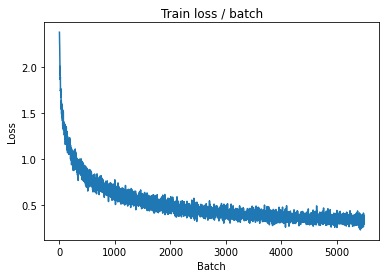


===============> Total time 15s	Avg loss 0.3399	Avg Prec@1 88.19 %	Avg Prec@5 99.61 %

[EVAL Batch 000/020]	Time 0.331s (0.331s)	Loss 0.4894 (0.4894)	Prec@1  83.4 ( 83.4)	Prec@5  99.4 ( 99.4)

===============> Total time 2s	Avg loss 0.4993	Avg Prec@1 83.44 %	Avg Prec@5 99.22 %



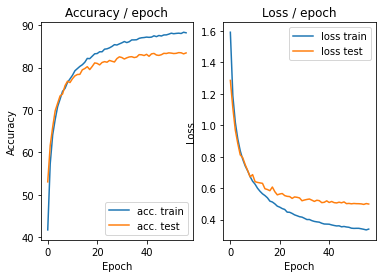

=== EPOCH 58 =====

[TRAIN Batch 000/098]	Time 0.432s (0.432s)	Loss 0.3215 (0.3215)	Prec@1  87.9 ( 87.9)	Prec@5  99.8 ( 99.8)


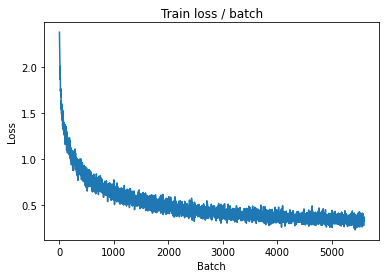


===============> Total time 15s	Avg loss 0.3320	Avg Prec@1 88.42 %	Avg Prec@5 99.69 %

[EVAL Batch 000/020]	Time 0.324s (0.324s)	Loss 0.4855 (0.4855)	Prec@1  82.8 ( 82.8)	Prec@5  99.6 ( 99.6)

===============> Total time 2s	Avg loss 0.5007	Avg Prec@1 83.44 %	Avg Prec@5 99.22 %



In [ ]:
  lr_grid = [1.0, 0.1, 0.01, 0.001]
  batch_size_grid = [64, 128, 256, 512]
  p_dropout_grid = np.arange(0.2,1,0.1)
  min_loss = 1e+10
  best_params={'learning_rate':0, 'batch_size':0, 'p_dropout':0, 'epoch':0}

  for lr in lr_grid:
    for bs in batch_size_grid:
      for p in p_dropout_grid:
        loss, min_epoch = main(bs, lr, epochs=150, proba_dropout=p, cuda=True)
        if loss < min_loss:
          min_loss = loss
          best_params['learning_rate'] = lr
          best_params['epoch'] = min_epoch
          best_params['batch_size'] = bs
          best_params['p_dropout'] = p



In [ ]:
print(min_loss)
print(best_params)

0.4706847369670868
{'learning_rate': 0.01, 'batch_size': 512, 'p_dropout': 0.6, 'epoch': 52}


In [ ]:
lr_grid = [1.0, 0.1, 0.01, 0.001]
  batch_size_grid = [64, 128, 256, 512]
  p_dropout_grid = np.arange(0.2,1,0.1)
  min_loss = 1e+10
  best_params={'learning_rate':0, 'batch_size':0, 'p_dropout':0, 'epoch':0}

  for lr in lr_grid:
    for bs in batch_size_grid:
      for p in p_dropout_grid:
        loss, min_epoch = main(bs, lr, epochs=150, proba_dropout=p, cuda=True)
        if loss < min_loss:
          min_loss = loss
          best_params['learning_rate'] = lr
          best_params['epoch'] = min_epoch
          best_params['batch_size'] = bs
          best_params['p_dropout'] = p